In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from functions.inequality import gini
from model import *
import statsmodels.api as sm
from matplotlib import style
from functions.evolutionaryalgo import *
import scipy.stats as stats
from SALib.sample import latin

In [2]:
style.use('ggplot')

# Asset price volatility and wealth inequality

This notebook contains the following steps:

1. Parameter calibration and estimation
2. Model dynamics
3. Experiment

## 1 Parameter calibration and estimation

### 1.1 Collect data

In [3]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price'])) #starting in 1952  was 1224
price_div = pd.Series(np.array(shiller_data.iloc[1174:-1]['CAPE']))
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]
pd_returns = pd.Series(np.array(shiller_data.iloc[1174:]['CAPE'])).pct_change()[1:]

### 1.2 calibration

First, I set two parameters for computational efficiency

Then, I calibrate parameters using data and literature. 

In [4]:
params = {"trader_sample_size": 10, # selected for comp efficiency
          "n_traders": 1000, # selected for comp efficiency
          "init_stocks": int((21780000000 / 267.33) / float(1000000)), # market valuation of Vanguard S&P 500 / share price 
          "ticks": len(p), # lenght of reference data
          "fundamental_value": p.mean(), # average value of reference data, assuming efficient markets
          "std_fundamental": p_returns.std(), # standard deviation of returns sp price, assuming efficient markets
          "base_risk_aversion": 0.7, # estimate from Kim & Lee (2012)
          'spread_max': 0.004087, # estimate from Riordan & Storkenmaier (2012)
          "horizon": int(len(p) * 0.35), # estimate based on average churn ratio found by Cella, Ellul and Giannetti (2013)
          "std_noise": 0.01, 
          "w_random": 0.1, 
          # parameter only used for experiment
          "mean_reversion": 0.0,
          # fixed / not modelled parameters
          "fundamentalist_horizon_multiplier": 1.0,
          "strat_share_chartists": 0.0,
          "mutation_intensity": 0.0,
          "average_learning_ability": 0.0,
          "trades_per_tick": 1
         }

In [5]:
params

{'trader_sample_size': 10,
 'n_traders': 1000,
 'init_stocks': 81,
 'ticks': 604,
 'fundamental_value': 1101.1096156039398,
 'std_fundamental': 0.036138325335996965,
 'base_risk_aversion': 0.7,
 'spread_max': 0.004087,
 'horizon': 211,
 'std_noise': 0.01,
 'w_random': 0.1,
 'mean_reversion': 0.0,
 'fundamentalist_horizon_multiplier': 1.0,
 'strat_share_chartists': 0.0,
 'mutation_intensity': 0.0,
 'average_learning_ability': 0.0,
 'trades_per_tick': 1}

Finally, there are two parameters left which are difficult to calibrate. Therefore, I estimate these values using the method of simulated moments. The starting point of this method is finding appropriate moments which the model should be able to replicate. I note that there should be more moments than parameters. Since 2 parameters need to be estimated, 3 moments are needed. Since this is a highly stylized model, I am only interested in the model replicating some basic moments of the price return series. The parameters are the average, standard deviation and average autocorrelation over 25 lags. 

First, I calculate these moments for the empirical data. 

In [6]:
emp_moments = np.array([
    p_returns.mean(),
    p_returns.std(),
    autocorrelation_returns(p_returns, 25),
    ])
emp_moments

array([0.00283408, 0.03613833, 0.00952201])

To account for the fact that some of these moments might correlate over different Monte Carlo Simulations, the MSM seeks to obtain a variance covariance matrix of the moments. Since there is only one empirical reality, I use a bootstrap procedure to create a covariance matrix of empirical moments. For this, I use a block bootstrap procedure.

In [7]:
BLOCK_SIZE = 25
BOOTSTRAPS = 100

In [8]:
p_data_blocks = []
for x in range(0, len(p_returns[:-3]), BLOCK_SIZE):
    p_data_blocks.append(p_returns[x:x + BLOCK_SIZE])

In [9]:
bootstrapped_p_returns = []
for i in range(BOOTSTRAPS):
    sim_data_p = [random.choice(p_data_blocks) for _ in p_data_blocks]
    sim_data2_p = [j for i in sim_data_p for j in i]
    bootstrapped_p_returns.append(sim_data2_p)

In [10]:
rets_mean = []
rets_std = []
rets_autocor = []

for rets in bootstrapped_p_returns:
    rets_mean.append(pd.Series(rets).mean())
    rets_std.append(pd.Series(rets).std())
    rets_autocor.append(autocorrelation_returns(rets, 25))

In [11]:
all_bootstrapped_moments = [rets_mean,
                            rets_std,
                            rets_autocor
                           ]

In [12]:
av_moments = [np.nanmean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_p_returns))]

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [13]:
W_hat = 1.0 / len(bootstrapped_p_returns) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])
W = np.linalg.inv(W_hat)
np.save('distr_weighting_matrix', W)

I establish confidence intervals for the moments

In [14]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [15]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

In [16]:
scores = [0 for x in moments_b[0]]
for bootstr in range(len(moments_b)):
    for idx, moment in enumerate(moments_b[bootstr]):
        if moment > confidence_intervals[idx][0] and moment < confidence_intervals[idx][1]:
            scores[idx] += 1
MCR_bootstrapped_moments = np.array(scores) / (np.ones(len(scores)) * len(moments_b))

To start the estimation procedure, I first sample the parameter space using Latin Hypercube sampling

In [17]:
population_size = 1

In [18]:
problem = {
  'num_vars': 2,
  'names': ['std_noise',
            'w_random'],
  'bounds': [[0.05, 0.20],
             [0.02, 0.20]]
}

In [19]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()
with open('hypercube.txt', 'w') as f:
    json.dump(latin_hyper_cube, f)
initial_params = latin_hyper_cube[0]
initial_params

[0.06534950720601601, 0.1234407159812486]

I perform the estimation excercise in a different Python file using multi-processing. I download the resulting paramters below.

In [20]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [21]:
for i, name in enumerate(problem['names']):
    params[name] = est_params[i]

In [9]:
# params['std_noise'] = 5.59
# params['w_random'] = 0.19

# Volatility inequality model

In [15]:
NRUNS = 2

In [52]:
trdrs0 = []
orbs0 = []
for seed in range(NRUNS): 
    traders0, orderbook0 = init_objects_distr(params, seed)
    traders0, orderbook0 = volatility_inequality_model2(traders0, orderbook0, params, seed)
    trdrs0.append(traders0)
    orbs0.append(orderbook0)

Start of simulation  0
Start of simulation  1


In [53]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs0, burn_in_period=0)

In [54]:
#mc_prices[0].pct_change().std()

In [55]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row]# / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

Identify individual wealth changes

In [56]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs0):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs0[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs0[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs0[seed].tick_close_price[-1] - orbs0[seed].tick_close_price[0]) / orbs0[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs0[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)

In [57]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

for t in range(params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

Text(0.5, 0, 'Agents')

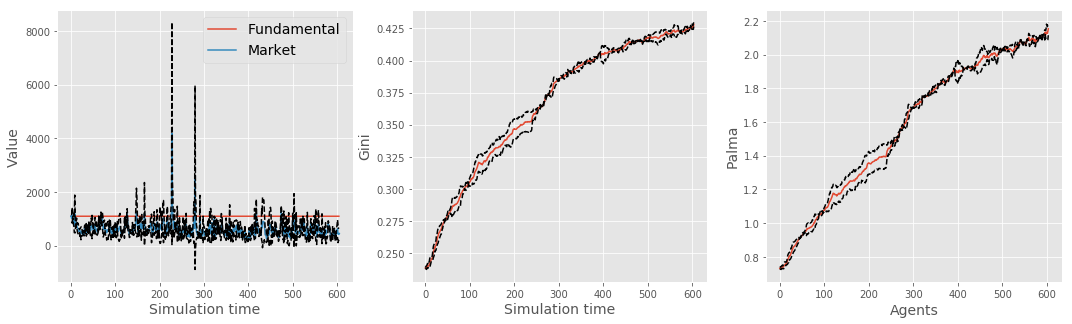

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
#ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), label='Market')
ax1.plot(mc_prices.index[:-1], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:-1], upper_c_price, 'k--')
ax1.legend(loc='best', fontsize='14')

ax1.set_ylabel('Value', fontsize='14')

ax2.plot(range(len(av_gini_ot[:])), av_gini_ot[:])
ax2.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax2.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax2.set_ylabel('Gini', fontsize='14')

ax3.plot(range(len(av_gini_ot[:])), av_palma_ot[:])
ax3.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax3.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax3.set_ylabel('Palma', fontsize='14')


for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Simulation time', fontsize='14')
    
ax3.set_xlabel('Agents', fontsize='14')

#fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment 

In [22]:
stdev_fun = [x / 100.0 for x in range(0, 750, 50)]

In [23]:
params['ticks'] = 600

In [24]:
NRUNS = 5

In [25]:
stdev_fun[0] = 0.0001

In [26]:
stdev_fun

[0.0001, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

In [27]:
experiments = len(stdev_fun)

In [28]:
trdrs = []
orbs = []
for exp in range(experiments):
    #params['std_fundamental'] = stdev_fun[exp]
    params['std_noise'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook = volatility_inequality_model2(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [29]:
full_stdev_fun = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev_fun.append(stdev_fun[exp])

In [30]:
ginis = []
palmas = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth))

In [31]:
# calc redistribution, profits ... abs 
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

In [32]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    g = ginis[y:y+NRUNS]
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))

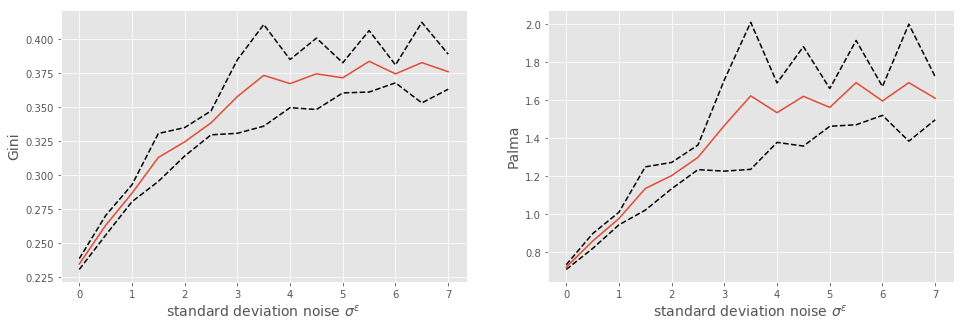

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1.plot(stdev_fun, gini_averages)
ax1.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, palma_averages)
ax2.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')

ax1.set_ylabel('Gini', fontsize=14)
ax2.set_ylabel('Palma', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_xlabel('standard deviation noise $\sigma^{\epsilon}$', fontsize=14)

fig.savefig('stdev_f_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Robustness check what if money is reset at the end of every simulation.

Then the effect disappears.

In [34]:
trdrs_hypo = []
orbs_hypo = []
for seed in range(NRUNS): 
    traders_hypo, orderbook_hypo = init_objects_distr(params, seed)
    traders_hypo, orderbook_hypo = volatility_inequality_model_reset_wealth(traders_hypo, orderbook_hypo, params, seed)
    trdrs_hypo.append(traders_hypo)
    orbs_hypo.append(orderbook_hypo)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4


In [35]:
for seed, traders in enumerate(trdrs_hypo):
    hypo_money_end = np.array([x.var.hypothetical_money[-1] for x in traders])
    hypo_stocks_end = np.array([x.var.hypothetical_stocks[-1] for x in traders])
    hypo_wealth_end = hypo_money_end + (hypo_stocks_end * orbs_hypo[seed].tick_close_price[-1])

NameError: name 'orbs0' is not defined

In [ ]:
share_top_10 = sum(np.sort(hypo_wealth_end - min(hypo_wealth_end))[int(len(hypo_wealth_end - min(hypo_wealth_end)) * 0.9):]) / sum(hypo_wealth_end - min(hypo_wealth_end))
share_bottom_40 = sum(np.sort(hypo_wealth_end - min(hypo_wealth_end))[:int(len(hypo_wealth_end - min(hypo_wealth_end)) * 0.4)]) / sum(hypo_wealth_end - min(hypo_wealth_end))
share_top_10 / share_bottom_40

In [ ]:
gini(hypo_wealth_end - min(hypo_wealth_end))

# Experiment 

In [37]:
stdev_fun = [x / 100.0 for x in range(0, 750, 50)]

In [38]:
NRUNS = 5

In [39]:
stdev_fun[0] = 0.0001

In [40]:
stdev_fun

[0.0001, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

In [41]:
experiments = len(stdev_fun)

In [42]:
#params['ticks'] = 1200

In [43]:
trdrs = []
orbs = []
for exp in range(experiments):
    #params['std_fundamental'] = stdev_fun[exp]
    params['std_noise'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook = volatility_inequality_model_reset_wealth(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [44]:
full_stdev_fun = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev_fun.append(stdev_fun[exp])

In [45]:
ginis = []
palmas = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.hypothetical_money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.hypothetical_stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    hypo_wealth = wealth - min(wealth)
    
    share_top_10 = sum(np.sort(hypo_wealth)[int(len(hypo_wealth) * 0.9):]) / sum(hypo_wealth)
    share_bottom_40 = sum(np.sort(hypo_wealth)[:int(len(hypo_wealth) * 0.4)]) / sum(hypo_wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(hypo_wealth))

In [46]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    g = ginis[y:y+NRUNS]
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))

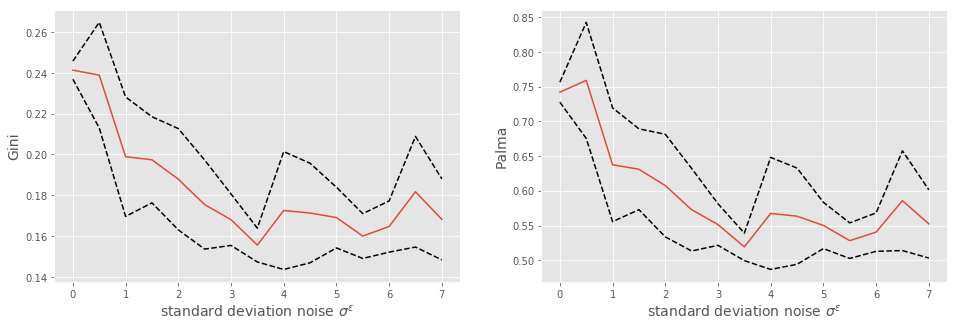

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1.plot(stdev_fun, gini_averages)
ax1.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, palma_averages)
ax2.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')

ax1.set_ylabel('Gini', fontsize=14)
ax2.set_ylabel('Palma', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_xlabel('standard deviation noise $\sigma^{\epsilon}$', fontsize=14)

fig.savefig('stdev_f_inequality_robustness_check.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)